<a href="https://colab.research.google.com/github/Ludvins/Practicas_PDGE/blob/master/CUDA/Reduccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El objetivo de este ejercicio es familiarizarse con un tipo de operaciones
muy común en computación científica: las reducciones. Una reducción
es una combinación de todos los elementos de un vector en un valor
único, utilizando para ello algún tipo de operador asociativo. Las
implementaciones paralelas aprovechan esta asociatividad para calcular
operaciones en paralelo, calculando el resultado en $O(\log N)$ pasos sin
incrementar el número de operaciones realizadas. 

En este ejercicio se trata de comparar diferentes patrones de acceso a
los datos para ir asociando por pares los operandos de cada operación.
Esto afecta al rendimiento de la memoria, y también a la complejidad de
programación, ya que las expresiones que hay que crear para que los
hilos generen los índices de acceso a sus datos en cada paso difieren en
dificultad.

# Diferentes paradigmas de reducción

## Caso 1

Este esquema de reducciónfunciona segun el siguiente esquema: (poner foto)

- Se lanzan tantos threads como elementos hay en el vector.
- Cada thread carga un elemento en un array de memoria compartida.
- Aumentando el valor de traslación en el vector (stride) se hacen los siguientes pasos:
  - Si el identificador de thread es múltiplo de 2 veces el stride, el thread añade el valor correspondiente a su identificador más el stride.

La ejecución seguiría la siguiente linea:
- Cada thread carga su posición en el array compartido.
- Los thread con identificador par (stride = 1), añaden a su posición la de la derecha (id + stride).
- Los thread con identificador multiplo de 4 (stride = 2), añaden a su posición la de dos veces su derecha (id + stride).

De esta forma se sigue el siguiente esqueña de reducción:


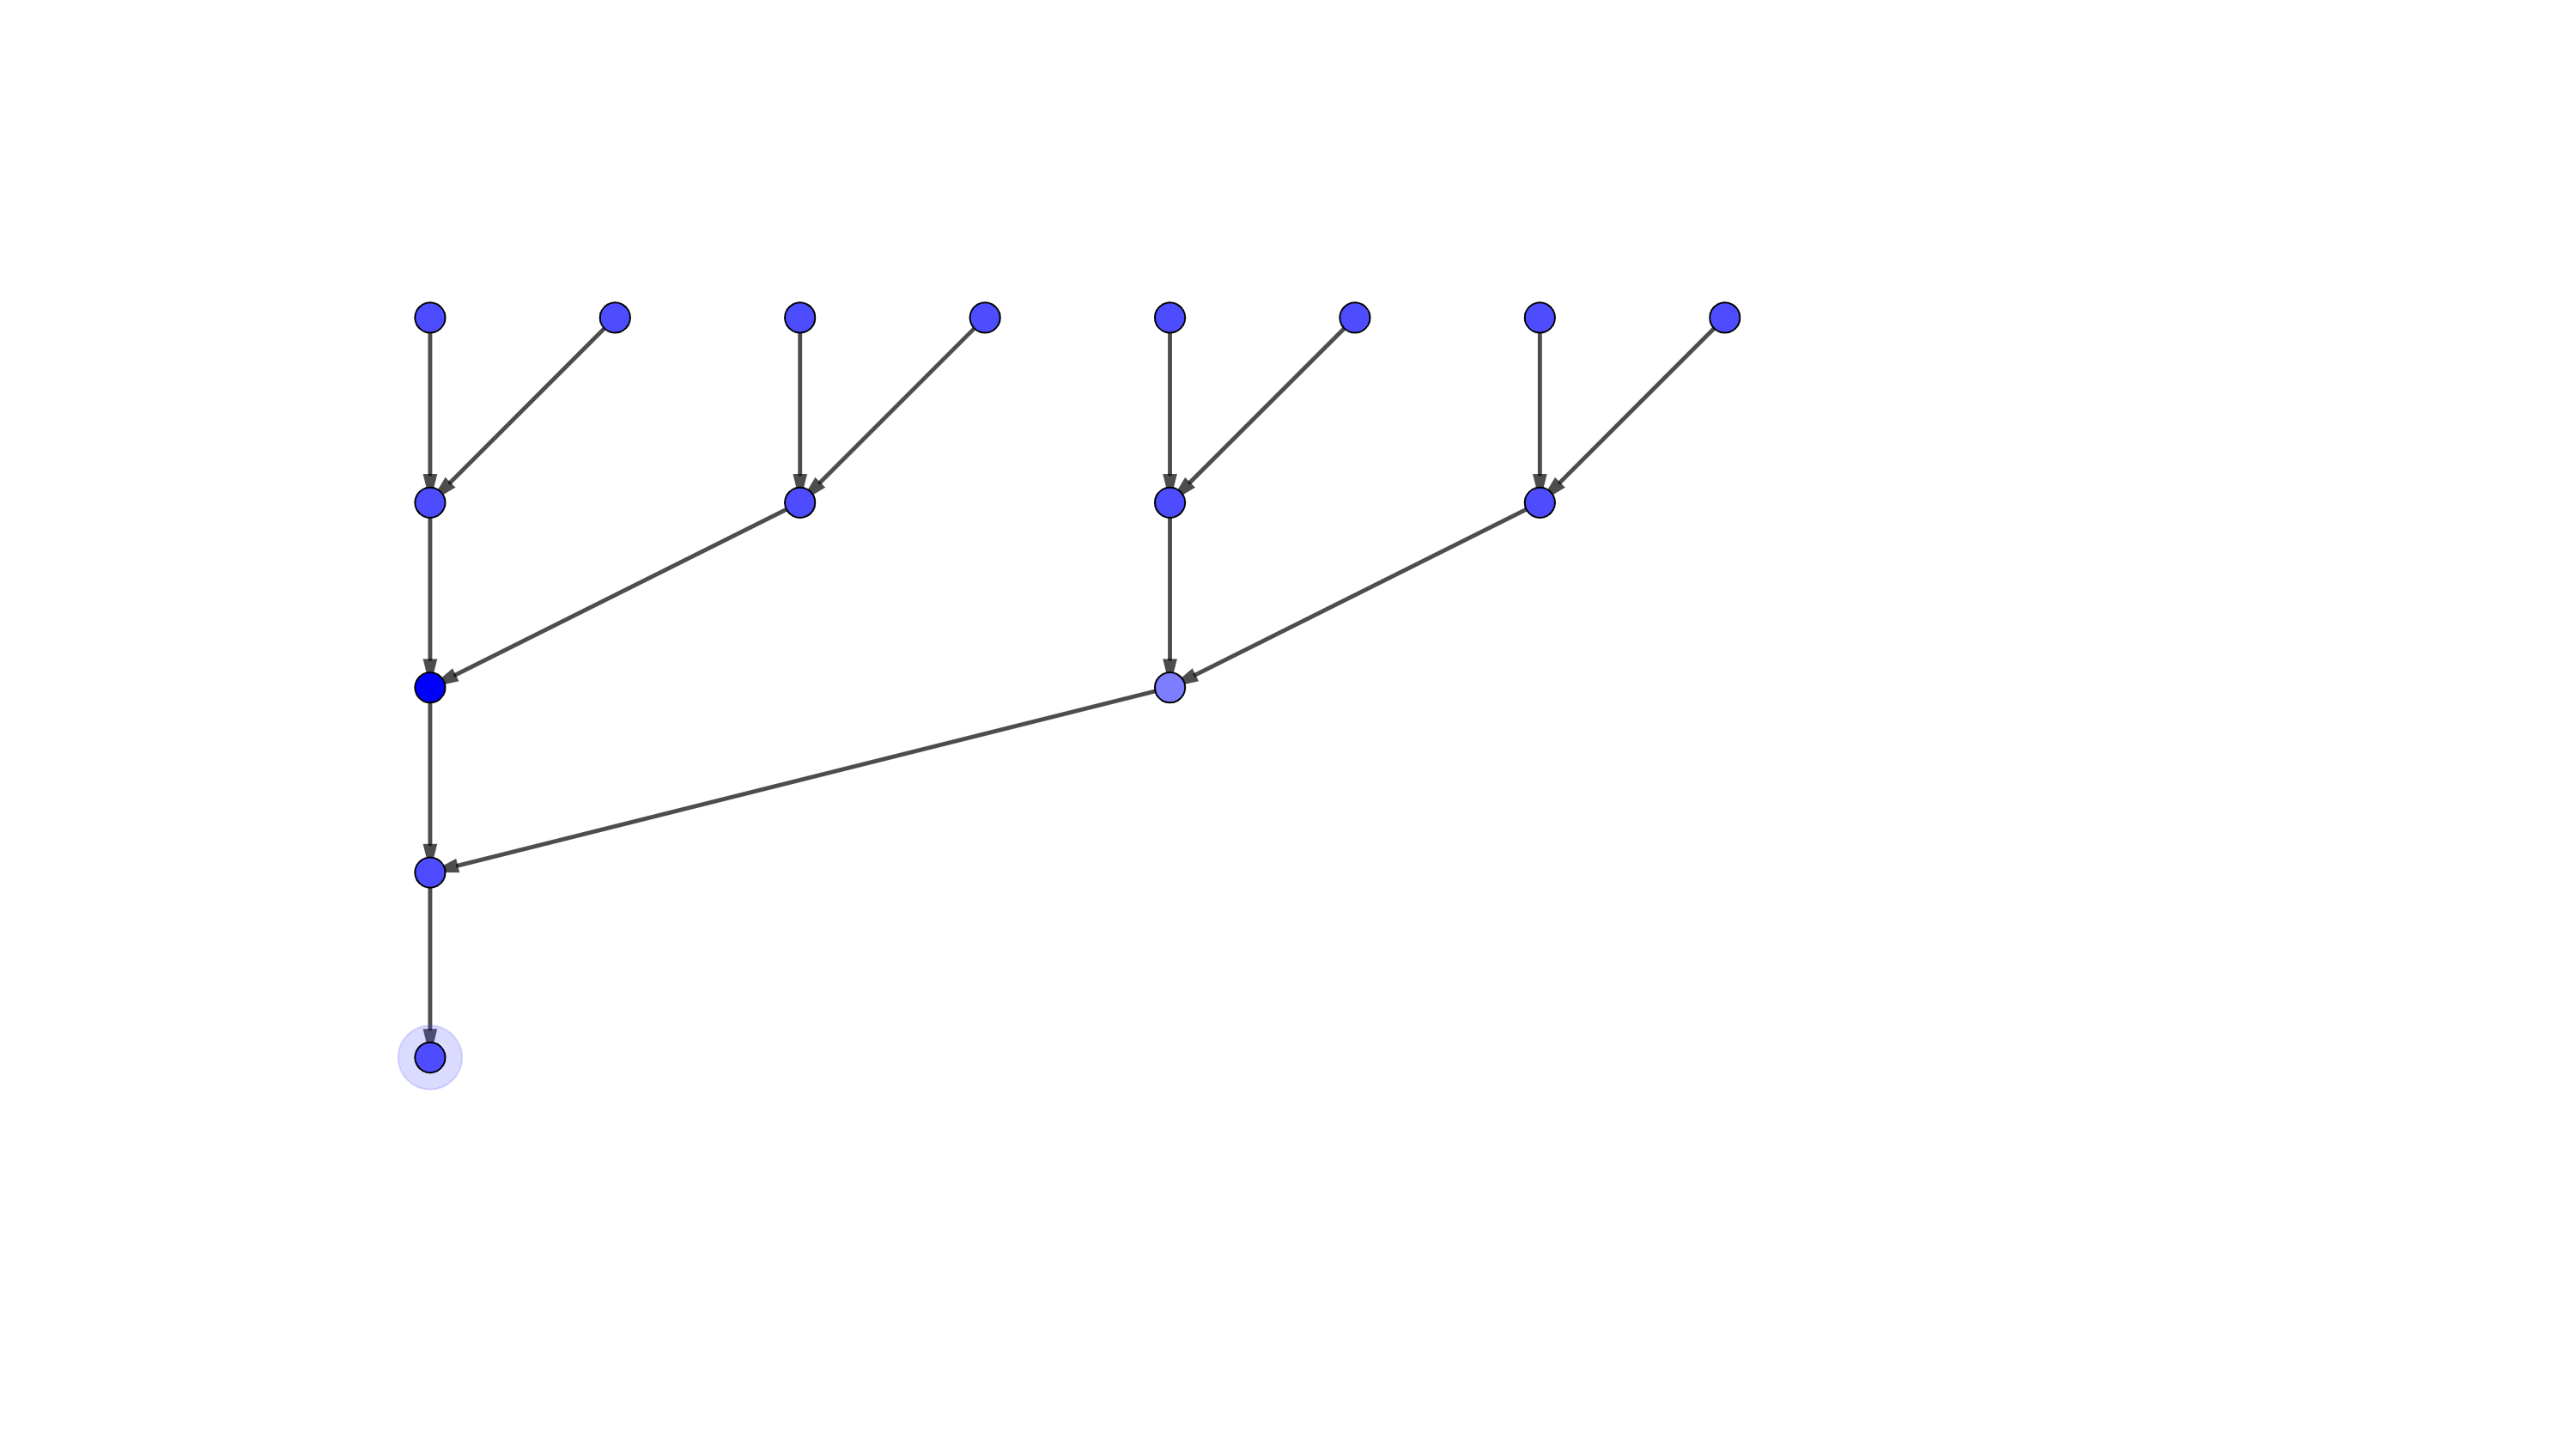

Como se puede ver, este esquema presenta las desventaja de que las hebras impares no realizan ninguna operación más alla de cargar sus respectivos datos en la memoria compartida.

In [1]:
%%writefile Reduction1.cu

#include <stdio.h>
#include <assert.h>

#define NUM_ELEMENTS 512

// **===------------------------------------------------------------------===**
//! @param g_idata  input data in global memory
//                  result is expected in index 0 of g_idata
//! @param n        input number of elements to scan from input data
// **===------------------------------------------------------------------===**
__global__ void reduction(float *g_data, int n){
  int stride;
  // Define shared memory
  __shared__ float scratch[NUM_ELEMENTS];
  // Load the shared memory
  scratch[threadIdx.x ] = g_data[threadIdx.x];
  __syncthreads();
  // Do sum reduction from shared memory
  for (stride = 1 ; stride < blockDim.x; stride *= 2) {
      __syncthreads();
      if (threadIdx.x % (2*stride) == 0)
              scratch[threadIdx.x] += scratch[threadIdx.x + stride];
      
  }
  // Store results back to global memory
  if(threadIdx.x == 0)
    g_data[0] = scratch[0];
  return;
}

float computeOnDevice(float* h_data, int num_elements)
{
  float* d_data = NULL;
  float result;
  // Memory allocation on device side
  cudaMalloc((void**)&d_data, num_elements*sizeof(float));
  // Copy from host memory to device memory
  cudaMemcpy(d_data, h_data, num_elements*sizeof(float), cudaMemcpyHostToDevice);

  int threads = num_elements;
  // Invoke the kernel
  reduction<<<1,threads>>>(d_data,num_elements);
  // Copy from device memory back to host memory
  cudaMemcpy(&result, d_data, sizeof(float), cudaMemcpyDeviceToHost);
  cudaFree(d_data);
  return result;
}


  
  void computeOnHost( float* reference, float* idata, const unsigned int len) 
{
  reference[0] = 0;
  double total_sum = 0;
  unsigned int i;
  for( i = 0; i < len; ++i) 
  {
      total_sum += idata[i];
  }
  reference[0] = total_sum;
}



////////////////////////////////////////////////////////////////////////////////
// Program main
////////////////////////////////////////////////////////////////////////////////
int main() {
    int num_elements = NUM_ELEMENTS;
    const unsigned int array_mem_size = sizeof( float) * num_elements;
    // allocate host memory to store the input data
    float* h_data = (float*) malloc( array_mem_size);
    // * No arguments: Randomly generate input data and compare against the host's 
    
            // initialize the input data on the host to be integer values
            // between 0 and 1000
            for( unsigned int i = 0; i < num_elements; ++i) 
            {
                //h_data[i] = floorf(1000*(rand()/(float)RAND_MAX));
                h_data[i] = i*1.0;
            }
       
        // compute reference solution
    float reference = 0.0f;  
    computeOnHost(&reference , h_data, num_elements);
  
   
    float result = computeOnDevice(h_data, num_elements);
    // We can use an epsilon of 0 since values are integral and in a range 
    // that can be exactly represented
    float epsilon = 0.0f;
    unsigned int result_regtest = (abs(result - reference) <= epsilon);
    printf( "Test %s\n", (1 == result_regtest) ? "PASSED" : "FAILED");
    printf( "device: %f  host: %f\n", result, reference);
    // cleanup memory
    free( h_data);
}

Writing Reduction1.cu


In [2]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true Reduction1.cu -o red1 -lcudadevrt


In [3]:
!./red1

Test PASSED
device: 130816.000000  host: 130816.000000


In [4]:
!nvprof ./red1

==126== NVPROF is profiling process 126, command: ./red1
Test PASSED
device: 130816.000000  host: 130816.000000
==126== Profiling application: ./red1
==126== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   69.72%  7.0720us         1  7.0720us  7.0720us  7.0720us  reduction(float*, int)
                   16.40%  1.6640us         1  1.6640us  1.6640us  1.6640us  [CUDA memcpy HtoD]
                   13.88%  1.4080us         1  1.4080us  1.4080us  1.4080us  [CUDA memcpy DtoH]
      API calls:   99.58%  169.19ms         1  169.19ms  169.19ms  169.19ms  cudaMalloc
                    0.24%  414.83us         1  414.83us  414.83us  414.83us  cuDeviceTotalMem
                    0.08%  136.69us        97  1.4090us     142ns  50.933us  cuDeviceGetAttribute
                    0.05%  76.801us         1  76.801us  76.801us  76.801us  cudaFree
                    0.02%  36.202us         2  18.101us  15.712us  20.490us  cudaMem

## Caso 2

En este caso, se lanzan la mitad de threads para solucionar el problema que tenía el modelo de reducción anterior, de forma que cada thread carga dos posiciones distintas.

Además, la técnica de reducción sigue otro enfoque distinto, en este, se pretende que los threads que sigan ejecutandose a lo largo de la reducción estén agrupados. Para ello, en este caso el stride se inicializa al número de threads / 2, dividiendolo entre 2 en cada iteración, y quedando el siguiente esquema:

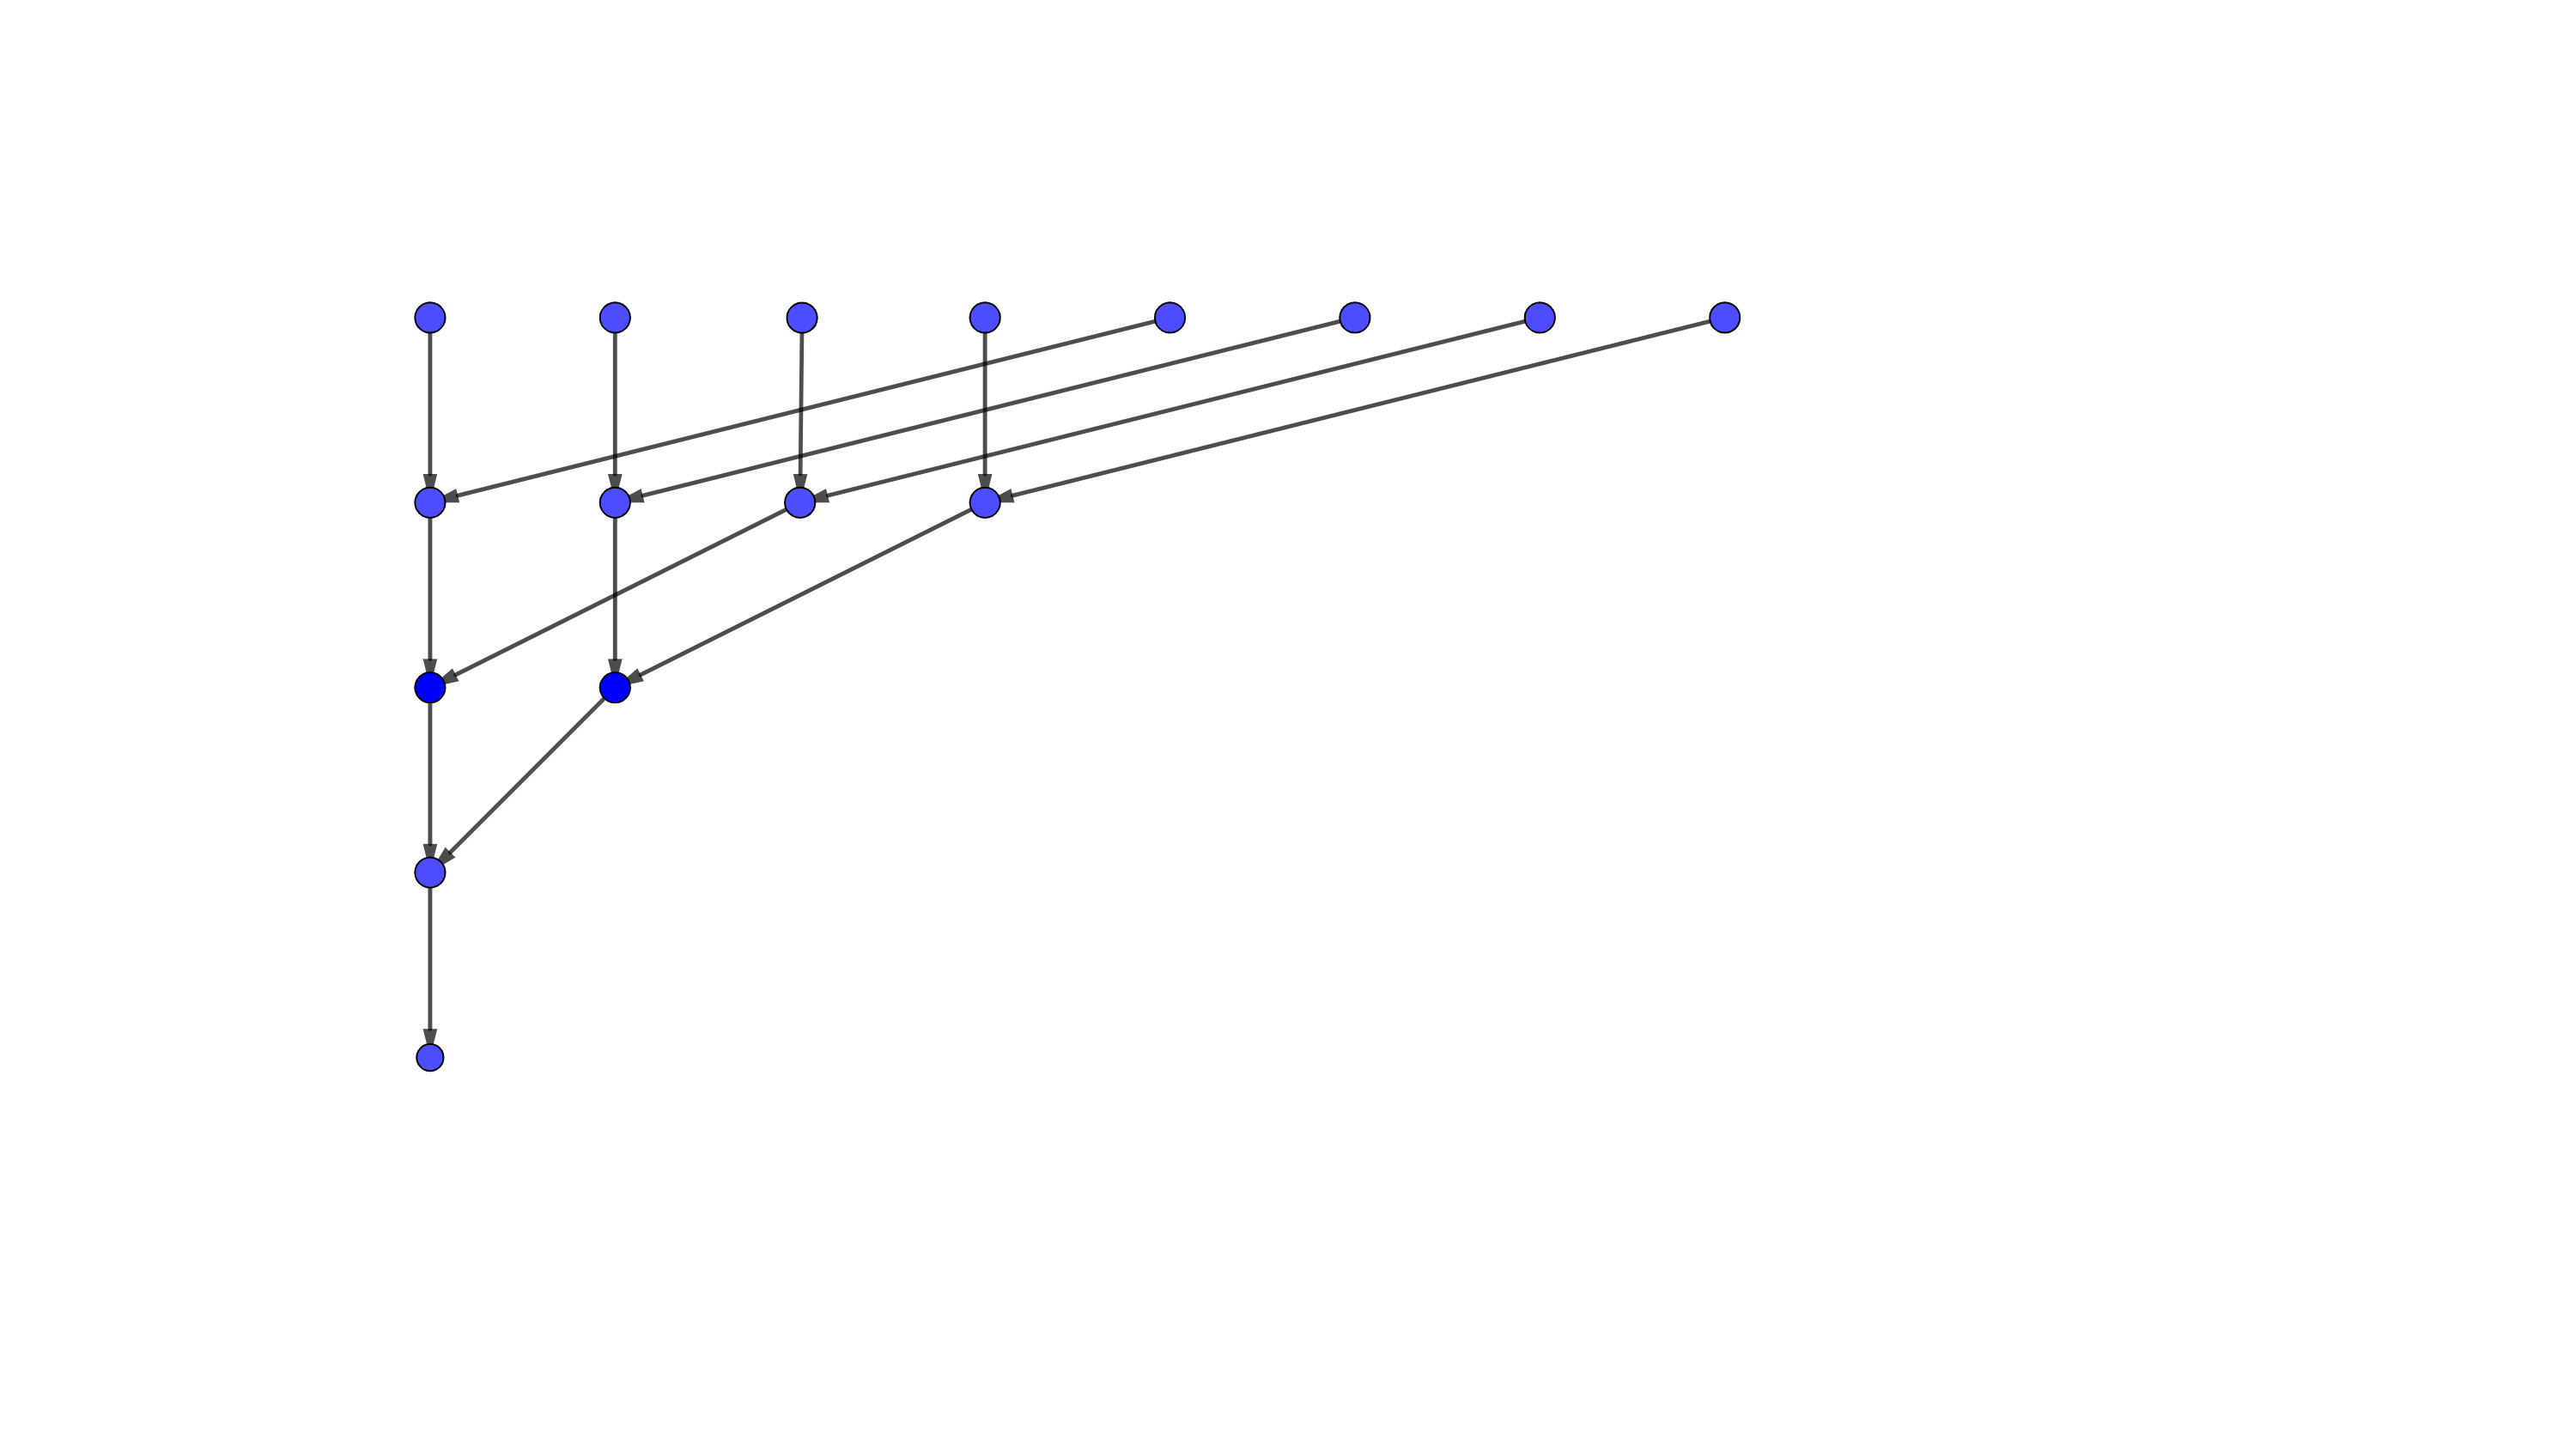

In [5]:
%%writefile Reduction2.cu
// includes, kernels
#include <stdio.h>
#include <assert.h>
#define NUM_ELEMENTS 512
// **===------------------------------------------------------------------===**
//! @param g_idata  input data in global memory
//                  result is expected in index 0 of g_idata
//! @param n        input number of elements to scan from input data
// **===------------------------------------------------------------------===**
__global__ void reduction(float *g_data, int n)
{
  int stride;
  // Define shared memory
  __shared__ float scratch[NUM_ELEMENTS];
  // Load the shared memory
  scratch[threadIdx.x ] = g_data[threadIdx.x];
  if(threadIdx.x + blockDim.x < n)
    scratch[threadIdx.x + blockDim.x] = g_data[threadIdx.x + blockDim.x];
  __syncthreads();
  // Do sum reduction from shared memory
 
  for (stride = NUM_ELEMENTS / 2; stride >= 1; stride >>= 1)
  {
      if(threadIdx.x < stride)
         scratch[threadIdx.x] += scratch[threadIdx.x + stride];
      __syncthreads();
  }
  // Store results back to global memory
  if(threadIdx.x == 0)
    g_data[0] = scratch[0];
  return;
}

  void computeOnHost( float* reference, float* idata, const unsigned int len) 
{
  reference[0] = 0;
  double total_sum = 0;
  unsigned int i;
  for( i = 0; i < len; ++i) 
  {
      total_sum += idata[i];
  }
  reference[0] = total_sum;
}

float computeOnDevice(float* h_data, int num_elements)
{
 float* d_data = NULL;
  float result;
  // Memory allocation on device side
  cudaMalloc((void**)&d_data, num_elements*sizeof(float));
  // Copy from host memory to device memory
  cudaMemcpy(d_data, h_data, num_elements*sizeof(float), cudaMemcpyHostToDevice);
  int threads = (num_elements/2) + num_elements%2;
  // Invoke the kernel
  reduction<<<1,threads>>>(d_data,num_elements);
  // Copy from device memory back to host memory
  cudaMemcpy(&result, d_data, sizeof(float), cudaMemcpyDeviceToHost);
  cudaFree(d_data);
  return result;
}
   


////////////////////////////////////////////////////////////////////////////////
// Program main
////////////////////////////////////////////////////////////////////////////////
int main() {
    int num_elements = NUM_ELEMENTS;
    const unsigned int array_mem_size = sizeof( float) * num_elements;
    // allocate host memory to store the input data
    float* h_data = (float*) malloc( array_mem_size);
    // * No arguments: Randomly generate input data and compare against the host's 
    
            // initialize the input data on the host to be integer values
            // between 0 and 1000
            for( unsigned int i = 0; i < num_elements; ++i) 
            {
                //h_data[i] = floorf(1000*(rand()/(float)RAND_MAX));
                h_data[i] = i*1.0;
            }
       
        // compute reference solution
    float reference = 0.0f;  
    computeOnHost(&reference , h_data, num_elements);
  
   
    float result = computeOnDevice(h_data, num_elements);
    // We can use an epsilon of 0 since values are integral and in a range 
    // that can be exactly represented
    float epsilon = 0.0f;
    unsigned int result_regtest = (abs(result - reference) <= epsilon);
    printf( "Test %s\n", (1 == result_regtest) ? "PASSED" : "FAILED");
    printf( "device: %f  host: %f\n", result, reference);
    // cleanup memory
    free( h_data);
}

Writing Reduction2.cu


In [6]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true Reduction2.cu -o red2 -lcudadevrt
!nvprof ./red2

==174== NVPROF is profiling process 174, command: ./red2
Test PASSED
device: 130816.000000  host: 130816.000000
==174== Profiling application: ./red2
==174== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   51.50%  3.8400us         1  3.8400us  3.8400us  3.8400us  reduction(float*, int)
                   29.18%  2.1760us         1  2.1760us  2.1760us  2.1760us  [CUDA memcpy HtoD]
                   19.31%  1.4400us         1  1.4400us  1.4400us  1.4400us  [CUDA memcpy DtoH]
      API calls:   99.64%  192.02ms         1  192.02ms  192.02ms  192.02ms  cudaMalloc
                    0.20%  385.22us         1  385.22us  385.22us  385.22us  cuDeviceTotalMem
                    0.07%  137.96us        97  1.4220us     145ns  50.623us  cuDeviceGetAttribute
                    0.04%  78.479us         1  78.479us  78.479us  78.479us  cudaFree
                    0.02%  39.019us         2  19.509us  19.271us  19.748us  cudaMem

# Caso 3

La idea es la misma que el anterior pero eligiendo segun la relación  id <-> N - id

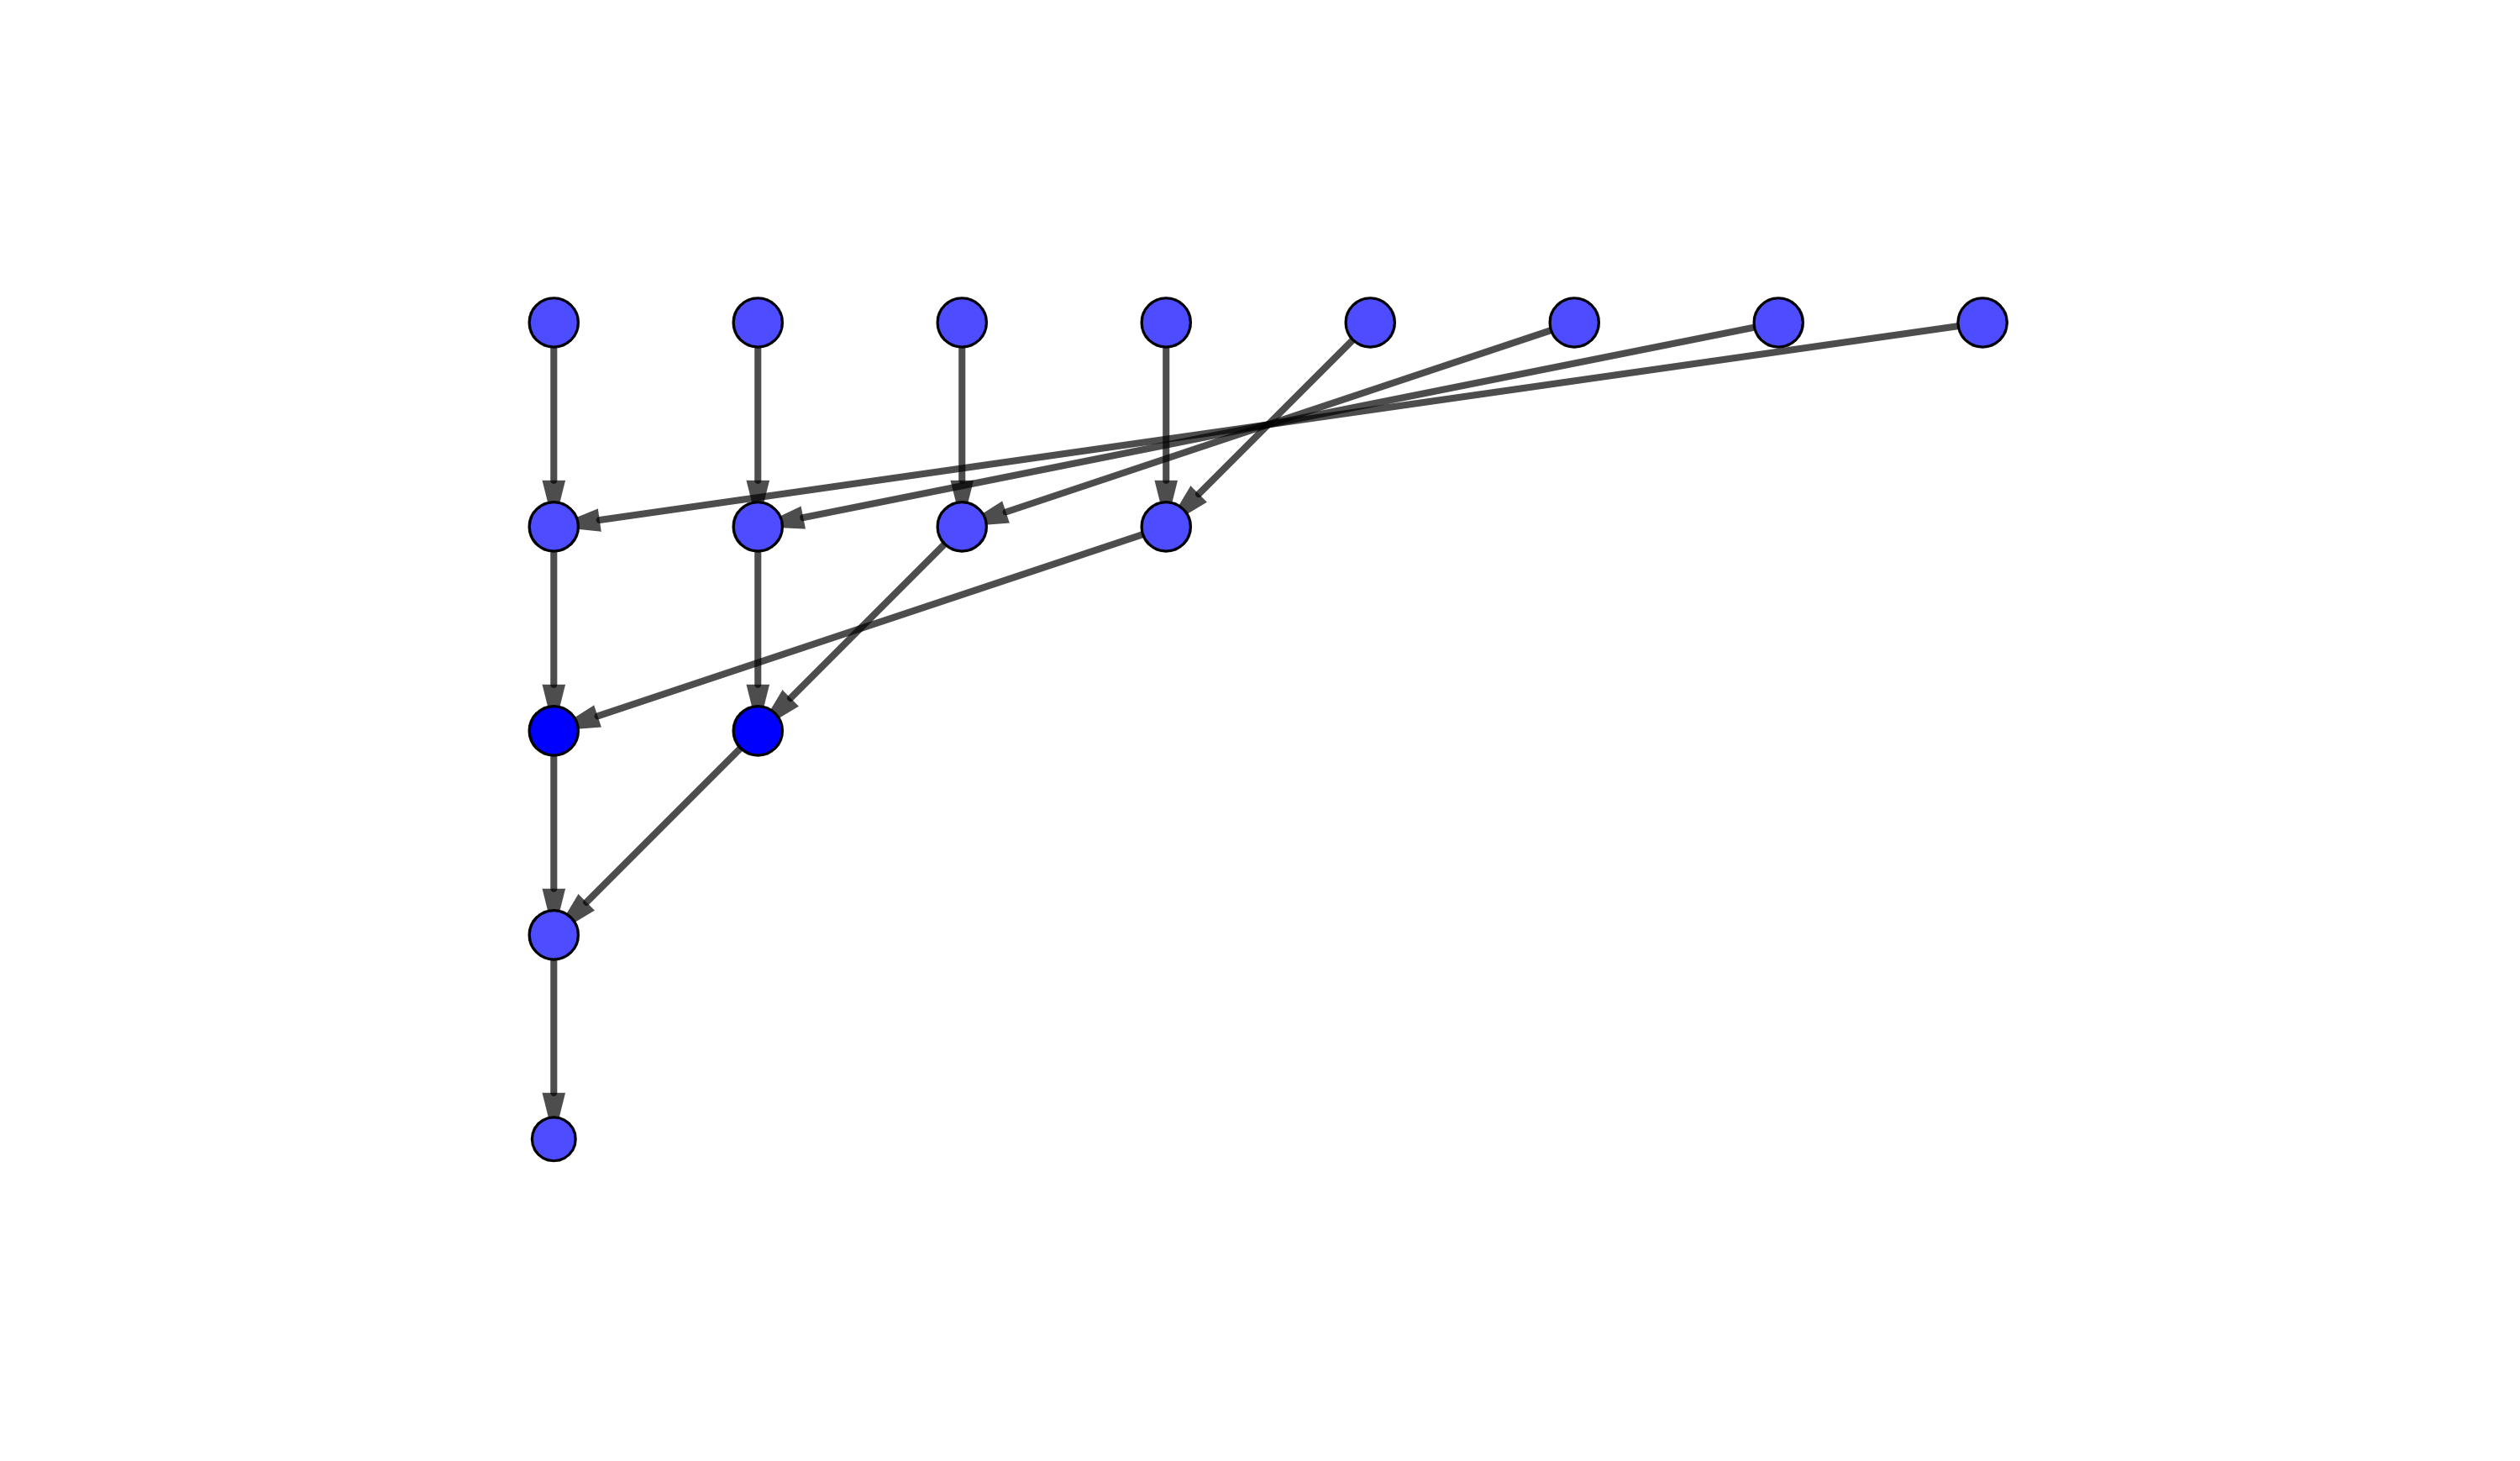

In [7]:
%%writefile Reduction3.cu

#include <stdio.h>
#include <assert.h>
#define NUM_ELEMENTS 512

__global__ void reduction(float *g_data, int n)
{
  int stride;
  // Define shared memory
  __shared__ float scratch[NUM_ELEMENTS];
  // Load the shared memory
  scratch[threadIdx.x ] = g_data[threadIdx.x];
  if(threadIdx.x + blockDim.x < n)
    scratch[threadIdx.x + blockDim.x] = g_data[threadIdx.x + blockDim.x];

  // Do sum reduction from shared memory
  for (stride = NUM_ELEMENTS; stride > 1; stride >>= 1) {
       __syncthreads();
       if (threadIdx.x < (stride>>1)) 
          scratch[threadIdx.x] += scratch[stride - threadIdx.x - 1];
  }
  __syncthreads();
  // Store results back to global memory
  if(threadIdx.x == 0)
    g_data[0] = scratch[0];
  return;
}


  void computeOnHost( float* reference, float* idata, const unsigned int len) 
{
  reference[0] = 0;
  double total_sum = 0;
  unsigned int i;
  for( i = 0; i < len; ++i) 
  {
      total_sum += idata[i];
  }
  reference[0] = total_sum;
}

float computeOnDevice(float* h_data, int num_elements)
{
 float* d_data = NULL;
  float result;
  // Memory allocation on device side
  cudaMalloc((void**)&d_data, num_elements*sizeof(float));
  // Copy from host memory to device memory
  cudaMemcpy(d_data, h_data, num_elements*sizeof(float), cudaMemcpyHostToDevice);
  int threads = (num_elements/2) + num_elements%2;
  // Invoke the kernel
  reduction<<<1,threads>>>(d_data,num_elements);
  // Copy from device memory back to host memory
  cudaMemcpy(&result, d_data, sizeof(float), cudaMemcpyDeviceToHost);
  cudaFree(d_data);
  return result;
}
   


////////////////////////////////////////////////////////////////////////////////
// Program main
////////////////////////////////////////////////////////////////////////////////
int main() {
    int num_elements = NUM_ELEMENTS;
    const unsigned int array_mem_size = sizeof( float) * num_elements;
    // allocate host memory to store the input data
    float* h_data = (float*) malloc( array_mem_size);
    // * No arguments: Randomly generate input data and compare against the host's 
    
            // initialize the input data on the host to be integer values
            // between 0 and 1000
            for( unsigned int i = 0; i < num_elements; ++i) 
            {
                //h_data[i] = floorf(1000*(rand()/(float)RAND_MAX));
                h_data[i] = i*1.0;
            }
       
        // compute reference solution
    float reference = 0.0f;  
    computeOnHost(&reference , h_data, num_elements);
  
   
    float result = computeOnDevice(h_data, num_elements);
    // We can use an epsilon of 0 since values are integral and in a range 
    // that can be exactly represented
    float epsilon = 0.0f;
    unsigned int result_regtest = (abs(result - reference) <= epsilon);
    printf( "Test %s\n", (1 == result_regtest) ? "PASSED" : "FAILED");
    printf( "device: %f  host: %f\n", result, reference);
    // cleanup memory
    free( h_data);
}



Writing Reduction3.cu


In [8]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true Reduction3.cu -o red3 -lcudadevrt
!nvprof ./red3

==222== NVPROF is profiling process 222, command: ./red3
Test PASSED
device: 130816.000000  host: 130816.000000
==222== Profiling application: ./red3
==222== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   51.65%  3.4870us         1  3.4870us  3.4870us  3.4870us  reduction(float*, int)
                   27.02%  1.8240us         1  1.8240us  1.8240us  1.8240us  [CUDA memcpy HtoD]
                   21.33%  1.4400us         1  1.4400us  1.4400us  1.4400us  [CUDA memcpy DtoH]
      API calls:   99.62%  200.44ms         1  200.44ms  200.44ms  200.44ms  cudaMalloc
                    0.20%  399.63us         1  399.63us  399.63us  399.63us  cuDeviceTotalMem
                    0.08%  153.34us        97  1.5800us     145ns  51.047us  cuDeviceGetAttribute
                    0.05%  102.29us         1  102.29us  102.29us  102.29us  cudaFree
                    0.02%  46.012us         2  23.006us  22.009us  24.003us  cudaMem

# Caso 4

El esquema es el mismo que en el caso 1 pero utilizando la mitad de threas (lo que yo pensaba pero implementado terrible)

La idea es que stride1 regula que cada thread controle las posiciones 2*id, 4*id, 8*id... dependiendo de la profundidad.

stride2 controla cuanto tienes que sumar en cada profundidad.

Ejemplo.

- stride1= 1, stride2=1
  - thread 0:  0 = 0 + 1
  - thread 1:  2 = 2 + 3
  - thread 2:  4 = 4 + 5

- stride1 = 2, stride2 = 2
  - thread 0:  0 = 0 + 2
  - thread 1:  4 = 4 + 6
  - thread 2:  8 = 8 + 10

El esquema de ejecución indicando que thread se encarga de cada nodo sería el siguiente:


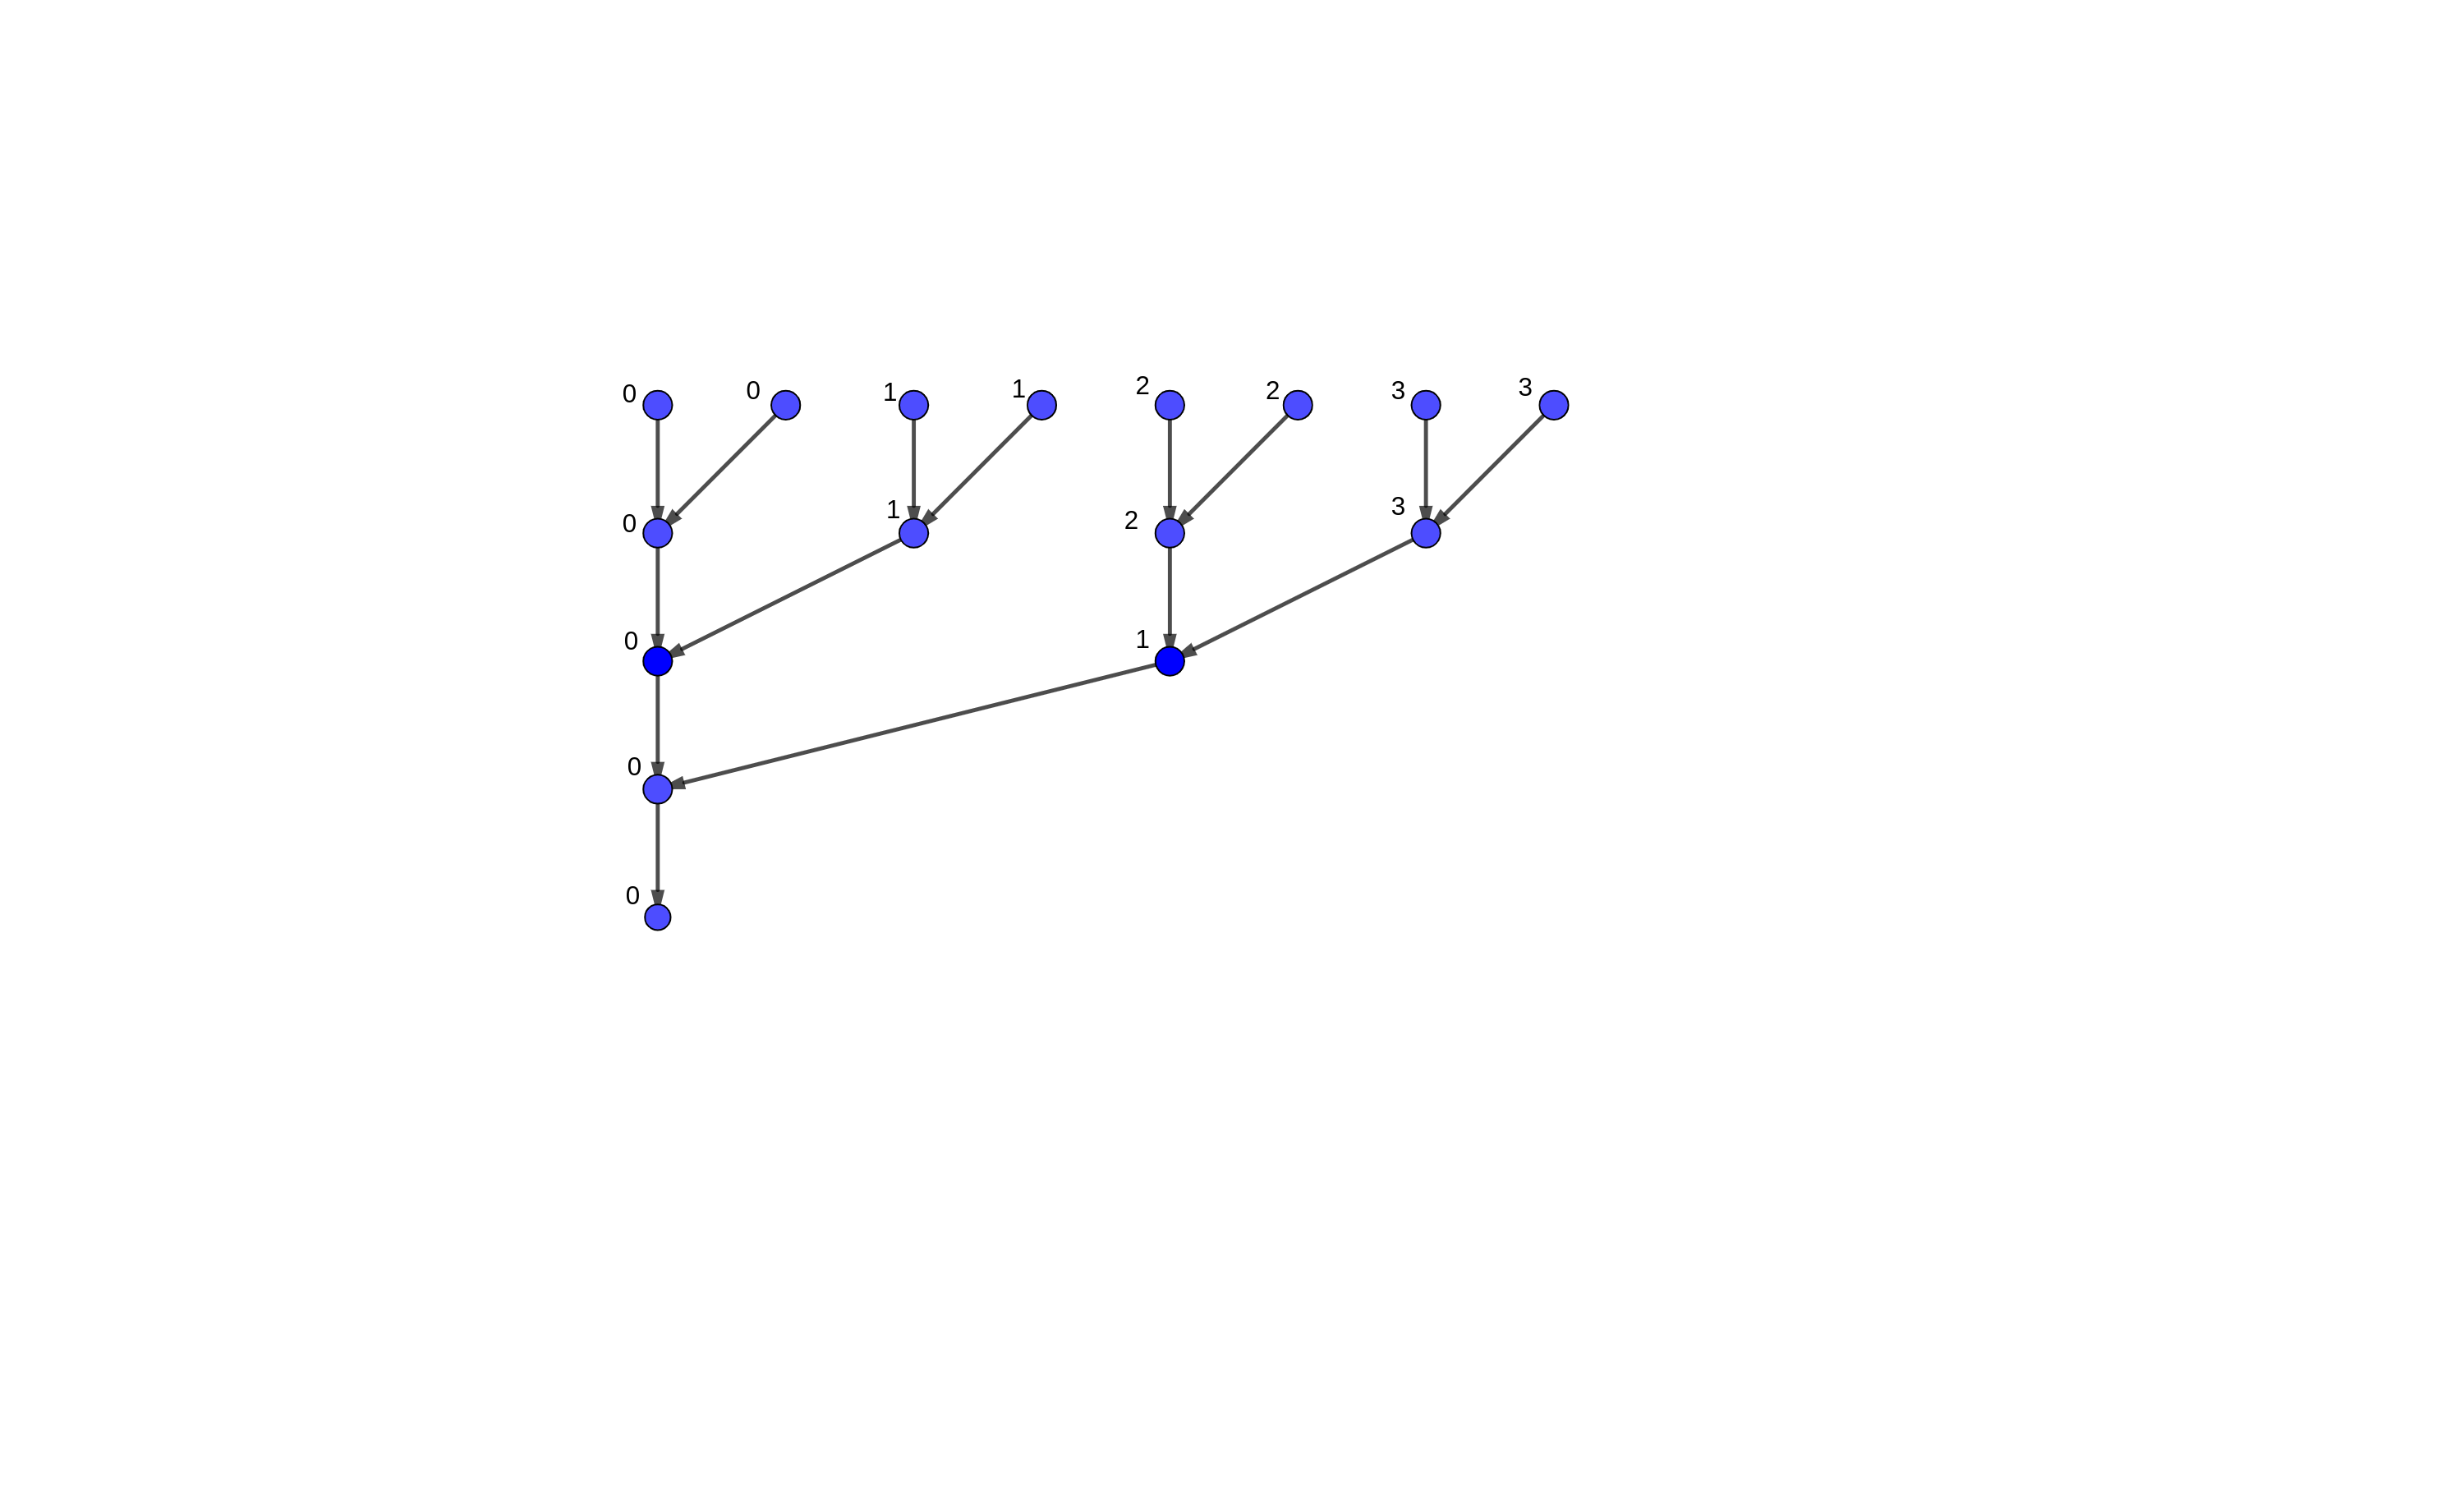

In [9]:
%%writefile Reduction4.cu

#include <stdio.h>
#include <assert.h>
#define NUM_ELEMENTS 512

__global__ void reduction(float *g_data, int n)
{
 int stride;
  // Define shared memory
  __shared__ float scratch[NUM_ELEMENTS];
  // Load the shared memory
  scratch[threadIdx.x ] = g_data[threadIdx.x];
  if(threadIdx.x + blockDim.x < n)
    scratch[threadIdx.x + blockDim.x] = g_data[threadIdx.x + blockDim.x];
  __syncthreads();
  // Do sum reduction from shared memory
  ///////  Reduction scheme 3 //////
  int stride2;
  for (stride = 1, stride2=1; stride <= 9; stride++, stride2<<=1)
  {
      int t = threadIdx.x << stride;
      if (t  + stride2 < n)
            scratch[ t ] = scratch[ t ]  + scratch[ t + stride2];
    __syncthreads();
  }
  // Store results back to global memory
  if(threadIdx.x == 0)
    g_data[0] = scratch[0];
  return;

}


  void computeOnHost( float* reference, float* idata, const unsigned int len) 
{
  reference[0] = 0;
  double total_sum = 0;
  unsigned int i;
  for( i = 0; i < len; ++i) 
  {
      total_sum += idata[i];
  }
  reference[0] = total_sum;
}

float computeOnDevice(float* h_data, int num_elements)
{
 float* d_data = NULL;
  float result;
  // Memory allocation on device side
  cudaMalloc((void**)&d_data, num_elements*sizeof(float));
  // Copy from host memory to device memory
  cudaMemcpy(d_data, h_data, num_elements*sizeof(float), cudaMemcpyHostToDevice);
  int threads = (num_elements/2) + num_elements%2;
  // Invoke the kernel
  reduction<<<1,threads>>>(d_data,num_elements);
  // Copy from device memory back to host memory
  cudaMemcpy(&result, d_data, sizeof(float), cudaMemcpyDeviceToHost);
  cudaFree(d_data);
  return result;
}
   


////////////////////////////////////////////////////////////////////////////////
// Program main
////////////////////////////////////////////////////////////////////////////////
int main() {
    int num_elements = NUM_ELEMENTS;
    const unsigned int array_mem_size = sizeof( float) * num_elements;
    // allocate host memory to store the input data
    float* h_data = (float*) malloc( array_mem_size);
    // * No arguments: Randomly generate input data and compare against the host's 
    
            // initialize the input data on the host to be integer values
            // between 0 and 1000
            for( unsigned int i = 0; i < num_elements; ++i) 
            {
                //h_data[i] = floorf(1000*(rand()/(float)RAND_MAX));
                h_data[i] = i*1.0;
            }
       
        // compute reference solution
    float reference = 0.0f;  
    computeOnHost(&reference , h_data, num_elements);
  
   
    float result = computeOnDevice(h_data, num_elements);
    // We can use an epsilon of 0 since values are integral and in a range 
    // that can be exactly represented
    float epsilon = 0.0f;
    unsigned int result_regtest = (abs(result - reference) <= epsilon);
    printf( "Test %s\n", (1 == result_regtest) ? "PASSED" : "FAILED");
    printf( "device: %f  host: %f\n", result, reference);
    // cleanup memory
    free( h_data);
}



Writing Reduction4.cu


In [10]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true Reduction4.cu -o red4 -lcudadevrt
!nvprof ./red4

==270== NVPROF is profiling process 270, command: ./red4
Test PASSED
device: 130816.000000  host: 130816.000000
==270== Profiling application: ./red4
==270== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   55.71%  3.9040us         1  3.9040us  3.9040us  3.9040us  reduction(float*, int)
                   23.74%  1.6640us         1  1.6640us  1.6640us  1.6640us  [CUDA memcpy HtoD]
                   20.55%  1.4400us         1  1.4400us  1.4400us  1.4400us  [CUDA memcpy DtoH]
      API calls:   99.62%  190.42ms         1  190.42ms  190.42ms  190.42ms  cudaMalloc
                    0.21%  394.21us         1  394.21us  394.21us  394.21us  cuDeviceTotalMem
                    0.08%  157.37us        97  1.6220us     145ns  63.422us  cuDeviceGetAttribute
                    0.04%  76.614us         1  76.614us  76.614us  76.614us  cudaFree
                    0.02%  41.017us         2  20.508us  19.807us  21.210us  cudaMem

# Generalización del caso más eficiente

Pasamos a generalizar a matrices de cualquier tamaño el caso más eficiente de entre los estudiados, el caso 2.

In [9]:
%%writefile Reduction.cu

#include <stdio.h>
#include <assert.h>
#define N 512
#define TPB 8

__global__ void reduction(float *g_data, int n)
{

  __shared__ float scratch[2*TPB];
 
  int gIndex = blockIdx.x * 2 * blockDim.x + threadIdx.x;
 
  scratch[threadIdx.x ] = g_data[gIndex];
 
  if(gIndex + blockDim.x < n)
    scratch[threadIdx.x + blockDim.x] = g_data[gIndex + blockDim.x];

  // Do sum reduction from shared memory
  for (int stride = 2*blockDim.x; stride > 1; stride >>= 1) {
       __syncthreads();
       if (threadIdx.x < (stride>>1)) 
          scratch[threadIdx.x] += scratch[stride - threadIdx.x - 1];
  }
  __syncthreads();
  // Store results back to global memory
  if(threadIdx.x == 0)
    g_data[0] += scratch[0];
  return;
}


  void computeOnHost( float* reference, float* idata, const unsigned int len) 
{
  reference[0] = 0;
  double total_sum = 0;
  unsigned int i;
  for( i = 0; i < len; ++i) 
  {
      total_sum += idata[i];
  }
  reference[0] = total_sum;
}

float computeOnDevice(float* h_data, int num_elements)
{
  float* d_data = NULL;
  float result;
 
  // Memory allocation on device side
  cudaMalloc((void**)&d_data, num_elements*sizeof(float));
  // Copy from host memory to device memory
  cudaMemcpy(d_data, h_data, num_elements*sizeof(float), cudaMemcpyHostToDevice);

  // Invoke the kernel
  reduction<<<(N + 2*TPB - 1)/(2*TPB),TPB>>>(d_data,num_elements);
 
  // Copy from device memory back to host memory
  cudaMemcpy(&result, d_data, sizeof(float), cudaMemcpyDeviceToHost);
  cudaFree(d_data);
  return result;
}
   


////////////////////////////////////////////////////////////////////////////////
// Program main
////////////////////////////////////////////////////////////////////////////////
int main() {
    int num_elements = N;
    const unsigned int array_mem_size = sizeof( float) * num_elements;
    // allocate host memory to store the input data
    float* h_data = (float*) malloc( array_mem_size);
    
    // initialize the input data on the host to be integer values
    // between 0 and 1000
    for( unsigned int i = 0; i < num_elements; ++i) 
        h_data[i] = i*1.0;
          
       
    // compute reference solution
    float reference = 0.0f;  
    computeOnHost(&reference , h_data, num_elements);
    float result = computeOnDevice(h_data, num_elements);
    
    // We can use an epsilon of 0 since values are integral and in a range 
    // that can be exactly represented
    float epsilon = 0.0f;
    unsigned int result_regtest = (abs(result - reference) <= epsilon);
    printf( "Test %s\n", (1 == result_regtest) ? "PASSED" : "FAILED");
    printf( "device: %f  host: %f\n", result, reference);
    // cleanup memory
    free( h_data);
}



Overwriting Reduction.cu


In [10]:
!/usr/local/cuda/bin/nvcc -arch=sm_35 -rdc=true Reduction.cu -o red -lcudadevrt
!nvprof ./red

==913== NVPROF is profiling process 913, command: ./red
Test FAILED
device: 6264.000000  host: 130816.000000
==913== Profiling application: ./red
==913== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   50.62%  3.9360us         1  3.9360us  3.9360us  3.9360us  reduction(float*, int)
                   25.10%  1.9520us         1  1.9520us  1.9520us  1.9520us  [CUDA memcpy HtoD]
                   24.28%  1.8880us         1  1.8880us  1.8880us  1.8880us  [CUDA memcpy DtoH]
      API calls:   99.65%  215.56ms         1  215.56ms  215.56ms  215.56ms  cudaMalloc
                    0.16%  346.24us         1  346.24us  346.24us  346.24us  cuDeviceTotalMem
                    0.07%  142.76us        97  1.4710us     133ns  59.863us  cuDeviceGetAttribute
                    0.05%  117.33us         1  117.33us  117.33us  117.33us  cudaFree
                    0.03%  73.247us         2  36.623us  24.207us  49.040us  cudaMemcpy
